In [1]:
%load_ext autoreload
%autoreload 2

# Creating Datasets

The first thing that you will need to train a model is a `Dataset`: an object containing data access and preparation functionality to make it ready for training a model. In this tutorial you will learn how to make a `Dataset` with `PytorchEO`.

## Creating Datasets with `LightningDataModule`

All `Datasets` in Pytorch EO are derived from `Pytorch Lighitning`'s `LightningDataModule`. Let's create a `Dataset` for EuroSAT. 

In [2]:
import os
from pytorch_eo.utils import download_url, unzip_file

def prepare_data(path):
	os.makedirs(path, exist_ok=True)
	url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
	compressed_data_filename = 'EuroSAT.zip'
	data_folder = '2750'
	compressed_data_path = path / compressed_data_filename
	download_url(url, compressed_data_path)
	unzip_file(compressed_data_path, path, msg="extracting data ...")
	uncompressed_data_path = path / data_folder
	classes = sorted(os.listdir(uncompressed_data_path))
	images, labels = [], []
	for ix, label in enumerate(classes):
		_images = os.listdir(uncompressed_data_path / label)
		images += [str(uncompressed_data_path /
					label / img) for img in _images]
		labels += [ix]*len(_images)
	return images, labels

Following the `LightningDataModule` convention, put all the processing steps inside the `setup` function. Then, create the `train_dataloader` function to return the training dataloader.

In [3]:
from pathlib import Path
from pytorch_eo.datasets import RGBImageDataset
from pytorch_eo.datasets import ConcatDataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class EuroSATDataset(pl.LightningDataModule):
	def __init__(self, path='data'):
		super().__init__()
		self.path = Path(path)

	def setup(self, stage=None):
		images, labels = prepare_data(self.path)
		images_ds = RGBImageDataset(images) 
		self.ds = ConcatDataset({'image': images_ds, 'label': labels})

	def train_dataloader(self):
		return DataLoader(self.ds)

/home/juan/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


With that, you already have a working Dataset ready to train.

> You can learn more about training models with Pytorch EO in the next tutorial.

Even though the Dataset is functional, you may want to do additional things such as:
- data splitting
- data augmentation
- performance optimizations

## Data Splitting

Use your favorite option for data splitting. Just make sure to create the `val_dataloader` and `test_dataloader` functions for validation and testing, respectively.

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd  

class EuroSATDataset(pl.LightningDataModule):
	def __init__(self, path='data', test_size=0.2, val_size=0.2):
		super().__init__()
		self.path = Path(path)
		self.test_size = test_size
		self.val_size = val_size

	def setup(self, stage=None):
		images, labels = prepare_data(self.path)
		df = pd.DataFrame({'image': images, 'label': labels})
		train_df, test_df = train_test_split(
			df,
			test_size=int(len(df)*self.test_size),
		)
		train_df, val_df = train_test_split(
			train_df,
			test_size=int(len(df)*self.val_size),
		)
		print("Training samples", len(train_df))
		print("Validation samples", len(val_df))
		print("Test samples", len(test_df))
		self.train_ds = self.get_dataset(train_df)
		self.val_ds = self.get_dataset(val_df)
		self.test_ds = self.get_dataset(test_df)

	def get_dataset(self, df):
		images_ds = RGBImageDataset(df.image.value) 
		return ConcatDataset({'image': images_ds, 'label': df.label.values})
		

	def train_dataloader(self):
		return DataLoader(self.train_ds)
	
	def val_dataloader(self):
		return DataLoader(self.val_ds)

	def test_dataloader(self):
		return DataLoader(self.test_ds)


## Data Augmentation

By default, we use `albumentations`.

In [5]:
class EuroSATDataset(pl.LightningDataModule):
	def __init__(self, path='data', trans=None):
		super().__init__()
		self.path = Path(path)
		self.trans = trans

	def setup(self, stage=None):
		images, labels = prepare_data(self.path)
		images_ds = RGBImageDataset(images) 
		self.ds = ConcatDataset({'image': images_ds, 'label': labels}, self.trans)

	def train_dataloader(self):
		return DataLoader(self.ds)

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(0, 1),
    ToTensorV2(),
])

ds = EuroSATDataset(trans=trans)
ds.setup()

extracting data ...: 100%|██████████| 27011/27011 [00:02<00:00, 11295.20it/s]


In [7]:
import matplotlib.pyplot as plt 

def plot_sample(ds, ix=10, image_key='image'):
	x = 5
	fig = plt.figure(figsize=(2*x, 5))
	for i in range(x):
		sample = ds.ds[10]
		image, label = sample[image_key], sample['label']
		ax = plt.subplot(1, x, i+1)
		ax.imshow(image.permute(1, 2, 0))
	plt.tight_layout()
	plt.show()

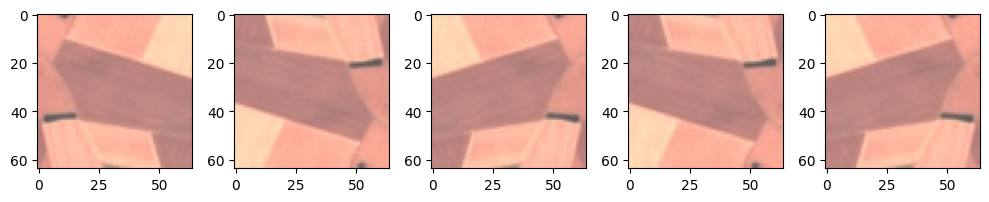

In [8]:
plot_sample(ds)

But you can use your own transfors (see an example in previous tutorial).

## Performance optimizations

You probably want to use a different batch size, and if training on GPU you also may want to tune the number of workers of the Dataloader.

In [9]:
class EuroSATDataset(pl.LightningDataModule):
	def __init__(self, path='data', batch_size=32, num_workers=4, pin_memory=True):
		super().__init__()
		self.path = Path(path)
		self.batch_size = batch_size
		self.num_workers = num_workers
		self.pin_memory = pin_memory

	def setup(self, stage=None):
		images, labels = prepare_data(self.path)
		images_ds = RGBImageDataset(images) 
		self.ds = ConcatDataset({'image': images_ds, 'label': labels})

	def train_dataloader(self):
		return DataLoader(self.ds, 
			batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=True
		)

## A Complete Example

Putting it all together, you can use this Dataset as a template for your own.

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd  

class EuroSATDataset(pl.LightningDataModule):
	def __init__(self, path='data', trans=None, test_size=0.2, val_size=0.2, batch_size=32, num_workers=4, pin_memory=True, verbose=True):
		super().__init__()
		self.path = Path(path)
		self.test_size = test_size
		self.val_size = val_size
		self.batch_size = batch_size
		self.num_workers = num_workers
		self.pin_memory = pin_memory
		self.trans = trans
		self.verbose = verbose

	def setup(self, stage=None):
		images, labels = prepare_data(self.path)
		self.df = pd.DataFrame({'image': images, 'label': labels})
		self.make_splits()
		self.train_ds = self.get_dataset(self.train_df, self.trans)
		self.val_ds = self.get_dataset(self.val_df) if self.val_df is not None else None
		self.test_ds = self.get_dataset(self.test_df) if self.test_df is not None else None

	def make_splits(self):
		if self.test_size > 0:
			train_df, self.test_df = train_test_split(
				self.df,
				test_size=int(len(self.df)*self.test_size),
			)
		else: 
			train_df, self.test_df = self.df, None
		if self.val_size > 0:
			self.train_df, self.val_df = train_test_split(
				train_df,
				test_size=int(len(self.df)*self.val_size),
			)
		else: 
			self.train_df, self.val_df = train_df, None
		if self.verbose:
			print("Training samples", len(self.train_df))
			if self.val_df is not None:
				print("Validation samples", len(self.val_df))
			if self.test_df is not None:
				print("Test samples", len(self.test_df))

	def get_dataset(self, df, trans=None):
		images_ds = RGBImageDataset(df.image.values) 
		return ConcatDataset({'image': images_ds, 'label': df.label.values}, trans=self.trans)
		
	def get_dataloader(self, ds, batch_size=None, shuffle=False):
		return DataLoader(
			ds, 
			batch_size=self.batch_size if batch_size is None else batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=shuffle
		)

	def train_dataloader(self, batch_size=None, shuffle=True):
		return self.get_dataloader(self.train_ds, batch_size, shuffle)
	
	def val_dataloader(self, batch_size=None, shuffle=False):
		return self.get_dataloader(self.val_ds, batch_size, shuffle) if self.val_ds is not None else None

	def test_dataloader(self, batch_size=None, shuffle=False):
		return self.get_dataloader(self.test_ds, batch_size, shuffle) if self.test_ds is not None else None

And use it to train a model (more on this in the next tutorial).

In [13]:
from pytorch_eo.tasks import ImageClassification
import torchvision
import torch

trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(0, 1),
    ToTensorV2(),
])

ds = EuroSATDataset(trans=trans, test_size=0.2, val_size=0.2)

model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, 10)

task = ImageClassification(model)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=5,
)

trainer.fit(task, ds)

/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
extracting data ...: 100%|██████████| 27011/27011 [00:02<00:00, 11127.18it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
----------------

Training samples 16200
Validation samples 5400
Test samples 5400


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [14]:
trainer.test(dataloaders=ds.test_dataloader())

/home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
extracting data ...: 100%|██████████| 27011/27011 [00:02<00:00, 11093.20it/s]
Restoring states from the checkpoint path at /home/juan/Desktop/pytorch_eo/tutorials/lightning_logs/version_7/checkpoints/epoch=4-step=2535.c

Training samples 16200
Validation samples 5400
Test samples 5400


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6961110830307007
        test_loss           0.9988016486167908
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.9988016486167908, 'test_acc': 0.6961110830307007}]